# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [2]:
#общая информация о данных
data.info()
#определим долю пропусков в каждом столбце и красиво раскрасим
pd.DataFrame(round((data.isna().mean()*100),2)).style.background_gradient('coolwarm')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,0
total_images,0
last_price,0
total_area,0
first_day_exposition,0
rooms,0
ceiling_height,38.8
floors_total,0.36
living_area,8.03
floor,0
is_apartment,88.29


### Вывод

Мы видим большое количество пропущенных значений в большинстве столбцов таблицы. 
Для некоторых из них можно предложить логичную замену - найти медиану по данным в других столбцах.

Построим таблицу корелляции для того, чтобы использовать для нахождения медианы те столбцы, от которых у столбцов с пропущенными значениями наибольшая зависимость. Конечно, мы будем руководствоваться, прежде всего, соображениями логики, а таблица корелляции лишь поможет нам подтвердить собственные догадки. 

In [3]:
corr = data.corr()
corr.style.background_gradient(cmap='PuBu').set_precision(2)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
total_images,1,0.1,0.12,0.099,-0.002,0.01,0.1,0.031,-0.029,-0.024,0.1,0.12,-0.0023,-0.048,0.021,-0.0083,-0.012,-0.003,-0.027
last_price,0.1,1,0.65,0.36,0.085,-0.007,0.57,0.027,-0.025,-0.0088,0.52,0.03,-0.026,-0.21,0.15,-0.016,0.16,-0.085,0.081
total_area,0.12,0.65,1,0.76,0.095,-0.076,0.94,-0.025,-0.073,-0.035,0.61,0.048,-0.031,-0.23,0.16,-0.021,0.16,-0.098,0.15
rooms,0.099,0.36,0.76,1,0.054,-0.23,0.85,-0.15,-0.15,-0.088,0.27,0.018,-0.061,-0.18,0.14,-0.055,0.093,-0.058,0.13
ceiling_height,-0.002,0.085,0.095,0.054,1,-0.029,0.091,-0.012,0.0017,0.043,0.088,0.041,-0.024,-0.092,0.066,-0.019,0.078,-0.059,0.019
floors_total,0.01,-0.007,-0.076,-0.23,-0.029,1,-0.17,0.68,0.07,0.051,0.16,0.19,0.11,0.02,-0.25,0.098,-0.12,0.039,-0.052
living_area,0.1,0.57,0.94,0.85,0.091,-0.17,1,-0.097,-0.056,-0.034,0.43,0.019,-0.058,-0.23,0.18,-0.05,0.15,-0.082,0.14
floor,0.031,0.027,-0.025,-0.15,-0.012,0.68,-0.097,1,0.037,0.036,0.14,0.17,0.072,0.0091,-0.16,0.073,-0.076,0.025,-0.039
studio,-0.029,-0.025,-0.073,-0.15,0.0017,0.07,-0.056,0.037,1,-0.0042,nan,0.031,-0.022,-0.007,-0.03,0.0091,0.00094,0.0026,-0.022
open_plan,-0.024,-0.0088,-0.035,-0.088,0.043,0.051,-0.034,0.036,-0.0042,1,nan,0.019,-0.014,-0.0042,-0.01,0.011,0.0085,-0.0033,-0.024


### Шаг 2. Предобработка данных

In [4]:
pd.DataFrame(round((data.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
total_images,0
last_price,0
total_area,0
first_day_exposition,0
rooms,0
ceiling_height,38.8
floors_total,0.36
living_area,8.03
floor,0
is_apartment,88.29


In [5]:
#удалим строки с пропущенными значениями в столбцах, 
#где пропущенные значения составляют менее 1%
data.dropna(subset=['floors_total', 'locality_name'], inplace=True)

In [6]:
#посмотрим на результат обработки
data['floors_total'].isnull().sum()

0

In [7]:
#посмотрим на результат обработки
data['locality_name'].isnull().sum()

0

In [8]:
#заполним пропуске в столбце ceiling_height медианой
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
#посмотрим на результат обработки
data['ceiling_height'].isnull().sum()

0

Столбец is_apartment возвращает True/False в зависимости от того, является ли недвижимость апаратаменами. Можно предположить, что пропуски означают то, что изначально собственником не была указана принадлежность недвижимости к типу "апартаменты", так как она таковым типом просто не является. В соответствии с этой логикой заполним все пропуски значеним False.

In [9]:
data['is_apartment'] = data['is_apartment'].fillna(False)
#проверим столбец на наличие пропусков после обработки
data['is_apartment'].isnull().sum()

0

Руководствуясь этой логикой, аналогичным образом избавимся от пропусков в столбце balcony

In [10]:
data['balcony'] = data['balcony'].fillna(0)
data['is_apartment'].isnull().sum()

0

Заполним пропуски в столбцах kitchen_area (площадь кухни), living_area(жилая площадь). 

Из таблицы корелляции наиболее очевидная зависимость у показателя жилой площади - от общей площади и количества комнат. В случае с кухней - от общей площади и цены недвижимости. 

Заполним пропуски в kitchen_area медианой по столбцу total_area:

In [11]:
#создадим категории для показателя total_area, чтобы найти медиану по каждой из категорий:
data['total_area_cat'] = pd.qcut(x = data['total_area'], 
                                 q = [0, .25, .5, .75, .99, 1.], 
                                 labels = ['очень маленькая', 'маленькая', 
                                           'средняя', 'большая', 'очень большая'])

In [12]:
#словарь с медианами на основе созданной категоризации:
total_area_dict = data.groupby('total_area_cat')['total_area'].median().to_dict()
total_area_dict
data['total_area_cat'] = data['total_area_cat'].astype('str')

In [13]:
#заменим пропуски в kitchen_area:
data['kitchen_area'] = data['kitchen_area'].fillna(
    data['total_area_cat'].map(total_area_dict))
##проверим столбец на наличие пропусков после обработки
data['kitchen_area'].isnull().sum()

0

Заполним пропуски в living_area медианой по столбцу total_area:

In [14]:
#заменим пропуски в living_area:
data['living_area'] = data['living_area'].fillna(
    data['total_area_cat'].map(total_area_dict))
##проверим столбец на наличие пропусков после обработки
data['living_area'].isnull().sum()

0

In [15]:
pd.DataFrame(round((data.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
total_images,0
last_price,0
total_area,0
first_day_exposition,0
rooms,0
ceiling_height,0
floors_total,0
living_area,0
floor,0
is_apartment,0


У нас осталось несколько столбцов с пропущенными данными - их объединяет то, что так или иначе их значение связано с локацией. Мы можем заполнить их по медиане от locality_name.

Но для начала давайте разберемся со столбцом locality_name

In [16]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Мы видим большое количество дублирующихся значений: для каждого значения, начинающегося с "деревня", "село" и. т.п. мы имеем дубликат, в названии которого отсутствует тип поселения. Избавимся от таких дубликатов!

In [17]:
#оставим только те слова, которые начинаются с большой буквы
#напишем следующую функцию
def new_loc (string):
    for i in range (len(string)):
        #для каждого знака аргумента в каждой строке
        if string[i].isupper():
            #если знак аргумента начинается с большой буквы
            return string[i:len(string)]
                #возвращаем все его оставшиеся знаки

In [18]:
#применим функцию к столбцу с данными
data['locality_name'] = data['locality_name'].apply(new_loc)

In [19]:
#посмотрим на результат обработки
data['locality_name'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

Заполним пропущенные значения в столбцах airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest медианой по столбцу 

In [20]:
data['airports_nearest'] = data['airports_nearest'].fillna(data['airports_nearest'].median())
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(data['cityCenters_nearest'].median())
data['parks_around3000'] = data['parks_around3000'].fillna(data['parks_around3000'].median())
data['parks_nearest'] = data['parks_nearest'].fillna(data['parks_nearest'].median())
data['ponds_around3000'] = data['ponds_around3000'].fillna(data['ponds_around3000'].median())
data['ponds_nearest'] = data['ponds_nearest'].fillna(data['ponds_nearest'].median())

In [21]:
pd.DataFrame(round((data.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
total_images,0
last_price,0
total_area,0
first_day_exposition,0
rooms,0
ceiling_height,0
floors_total,0
living_area,0
floor,0
is_apartment,0


Перейдем к пропущенным значениям в days_exposition. Вероятно, они связаны с тем, что соответствующее объявление просто не было снято с публикации (квартира до сих пор в продаже). Заполнить данные пропуски невозможно, так как они являются обоснованными. 

Изменим типы данных там, где это необходимо. Приведем к целым числам значения в следующих столбцах: floors_total, balcony, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition.

In [22]:
data['floors_total'].round
data['balcony'].round
data['airports_nearest'].round
data['cityCenters_nearest'].round
data['parks_around3000'].round
data['parks_nearest'].round
data['ponds_around3000'].round
data['ponds_nearest'].round
data['days_exposition'].round

<bound method Series.round of 0          NaN
1         81.0
2        558.0
3        424.0
4        121.0
         ...  
23694      NaN
23695     45.0
23696      NaN
23697    602.0
23698      NaN
Name: days_exposition, Length: 23565, dtype: float64>

<div class="alert alert-info">
Приведем данные к типу int   
</div>

In [23]:
data['floors_total'].astype('int64')
data['balcony'].astype('int64')
data['airports_nearest'].astype('int64')
data['cityCenters_nearest'].astype('int64')
data['parks_around3000'].astype('int64')
data['parks_nearest'].astype('int64')
data['ponds_around3000'].astype('int64')
data['ponds_nearest'].astype('int64')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 23 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
first_day_exposition    23565 non-null object
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null float64
living_area             23565 non-null float64
floor                   23565 non-null int64
is_apartment            23565 non-null bool
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            23565 non-null float64
balcony                 23565 non-null float64
locality_name           23565 non-null object
airports_nearest        23565 non-null float64
cityCenters_nearest     23565 non-null float64
parks_around3000        23565 non-null float64
parks_nearest           23565 non-null float64
ponds_around300

Мы заполнили пропуски в данных там, где это было необходимо и возможно было логически. Где логика не работала - я применил медиану по столбцу. Возможно, это и правда не лучшее решение, когда количество пропусков составляет порядка 20% от общего количества данных - стоит внимательней отнестись к таким исходным и проверить характер пропусков, а также внимательно разоробраться в их причинах. 
    
От себя отмечу, что, конечно, такой способ заполнения пропусков совсем не идеален, тем более когда есть высокая корелляция сразу по нескольким показателям. В таких случаях, мне кажется, стоит рассчитывать данные для заполнения пропусков, учитывая все имеющиеся связи. 

Мы избавились от дубликатов в столце locality_name, убрав слова, указывающие на тип поселения. 

Также, заполнили/удалили пропуски в следущих столбцах:
    
- floors_total, locality_name - удалили пропуски, так их количество составляло менее 1% и не искажало общую картину
    
- kitchen_area, living_area - заполнили пропуски медианой по total_area, так как данные сильно кореллируют со значениями из этого столбца
    
- пропущенные значения в столбцах airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest заполнили медианой по собственным значениям столбцов
    
- пропуски в столбцах days_exposition оставил без изменения, так как отсутствие данных указывает на то, что объявление не снято с публикации

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 23 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
first_day_exposition    23565 non-null object
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null float64
living_area             23565 non-null float64
floor                   23565 non-null int64
is_apartment            23565 non-null bool
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            23565 non-null float64
balcony                 23565 non-null float64
locality_name           23565 non-null object
airports_nearest        23565 non-null float64
cityCenters_nearest     23565 non-null float64
parks_around3000        23565 non-null float64
parks_nearest           23565 non-null float64
ponds_around300

### Шаг 3. Посчитайте и добавьте в таблицу

Добавим в таблицу цену квадратного метра.

In [25]:
data['m_price'] = data['last_price'] / data['total_area']

Добавим день недели, месяц и год публикации.

In [26]:
data['weekday'] = pd.DatetimeIndex(data['first_day_exposition']).weekday
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year

Добавим в таблицу категории этажей: первый, последний или другой. 

In [27]:
def floor_type(row):
    floor = row['floor']         
    total = row['floors_total']  
    if floor == 1:               
        floor = 'Первый'    
        return floor             
    elif floor == total:         
        floor = 'Последний' 
        return floor             
    else:                        
        floor = 'Другой'    
        return floor            

data['floor_type'] = data.apply(floor_type, axis=1)

data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_cat,m_price,weekday,month,year,floor_type
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,...,482.0,2.0,755.0,NaN,большая,120370.370370,3,3,2019,Другой
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,2.65,11.0,18.6,1,False,...,455.0,0.0,503.0,81.0,маленькая,82920.792079,1,12,2018,Первый
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,2.65,5.0,34.3,4,False,...,90.0,2.0,574.0,558.0,средняя,92785.714286,3,8,2015,Другой
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,2.65,14.0,85.6,9,False,...,84.0,3.0,234.0,424.0,большая,408176.100629,4,7,2015,Другой
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,...,112.0,1.0,48.0,121.0,большая,100000.000000,1,6,2018,Другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,False,...,796.0,3.0,381.0,NaN,большая,72490.845228,1,3,2017,Другой
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,2.65,5.0,38.0,4,False,...,455.0,1.0,503.0,45.0,средняя,52542.372881,0,1,2018,Другой
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,2.65,3.0,29.7,1,False,...,455.0,1.0,503.0,NaN,средняя,44091.710758,6,2,2018,Первый
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,85.6,12,False,...,173.0,3.0,196.0,602.0,большая,149511.400651,1,3,2017,Другой


Найдем и добавим в таблицу соотношение жилой и общей площади, а также отношение площади кухни к общей:

In [28]:
data['living_ratio'] = data['living_area'] / data['total_area']

In [29]:
data['kitchen_ratio'] = data['kitchen_area'] / data['total_area']

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

Построим гистрограммы для следующих параметров: площадь, цена, число комнат, высотка потолков.

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

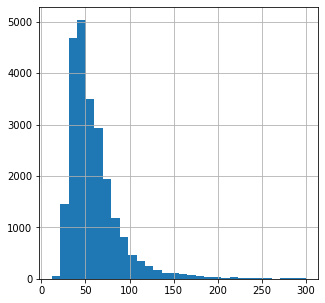

In [30]:
import matplotlib.pyplot as plt
import numpy as np
#гистограмма по данным об общей площади жилья
data['total_area'].hist(range = (12, 300), bins=30, figsize=(5,5))
data['total_area'].describe()

Обратим внимание на пиковые значения в районе 50 кв.м. Это наиболее часто встречающиеся показатели общей площади. Значения > 150 кв.м. встречаются крайне редко.

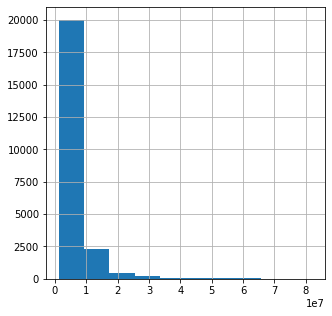

In [31]:
#гистограмма цены
data['last_price'].hist(figsize=(5, 5), range=(1200000,82000000), bins=10)

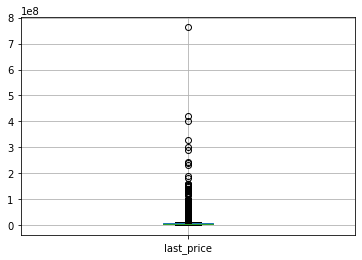

In [32]:
data.boxplot(column=['last_price'])

In [33]:
data['last_price'].describe()

count    2.356500e+04
mean     6.540058e+06
std      1.091093e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.646000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64

Значения больше 20000000 млн.руб. встречаются очень редко и стремятся к нулю.

count    23565.000000
mean         2.070656
std          1.078591
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

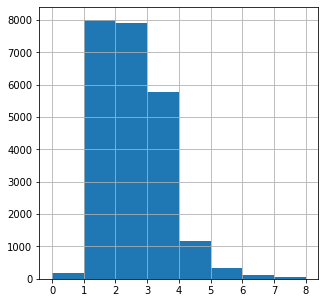

In [34]:
#гистограмма по данным о количестве комнат
data['rooms'].hist(bins=8, figsize=(5, 5), range = (0, 8))
data['rooms'].describe()

Данные, которые мы можем ислледовать, относятся к диапазону от 1 до 5 комнат. Это наиболее часто встречающиеся значения. 

count    23565.000000
mean         2.724530
std          0.991026
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

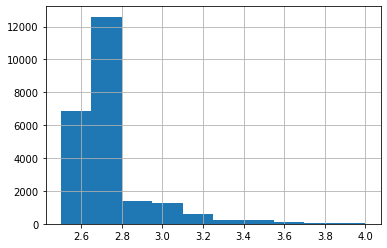

In [35]:
#гистограмма по данным о высоте потолков
data['ceiling_height'].hist(range=(2.5,4), bins=10)
data['ceiling_height'].describe()

Потолки больше 3 метров и меньше 2 - это определенно эксклюзивные предложения, которые слабо учавствуют в общей картине. 

ВРЕМЯ ПРОДАЖИ.

Изучим данные о времени продажи квартир.

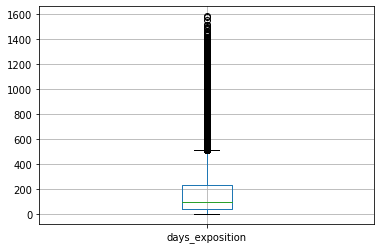

In [36]:
data.boxplot(column=['days_exposition'])

In [37]:
data['days_exposition'].describe()

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [38]:
data['days_exposition'].median()

95.0

Как мы видим, в среднем, продажа занимает 180 дней. При этом продажа, совершенная больше, чем через 500 дней после публикации объявления, встречается уже гораздо реже - такие продажи можно считать слишком долгими, так как в boxplot они относятся к очевидным выбросам. 

Объявления же, которые были закрыты в сроки до 100 дней, можно отнести к быстрым продажам, так как они попадают в диапазоны 30/60/90 дней - это сроки размещения бесплатных объявлений. 

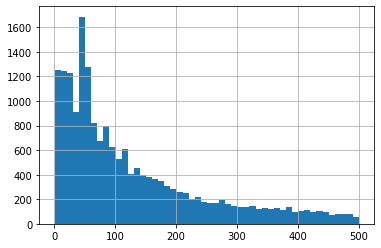

In [39]:
data['days_exposition'].hist(range=(1,500),bins=50)

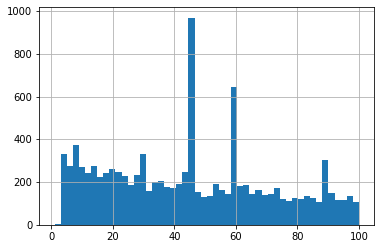

In [40]:
data['days_exposition'].hist(range=(1,100),bins=50)

Также мы можем обратить наше внимание на пиковые значения на отметках 45/60/90 дней. Предположим, что в эти сроки предоставляется бесплатное размещение объявлений, поэтому по истечении 45/60/90 дней соответственно объявления закрываются наиболее часто. 

РЕДКИЕ И ВЫБИВАЮЩИЕСЯ ЗНАЧЕНИЯ

Избавимся от редких значений в общей площади. Как мы заметили ранее, значения больше 150 кв/м можно считать выбросами. 

In [41]:
data=data.query('20 < total_area < 150')

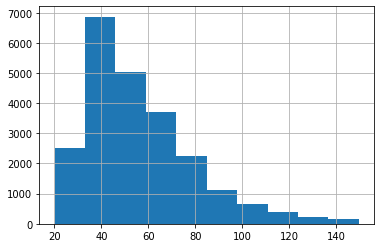

In [42]:
data['total_area'].hist()

Пиковые значения сконцентрированы в районе 30-50 кв.м. Это значит, что подавляющая часть объявлений о продаже недвижимости на рынке - это 1-кмн. квартиры или студии. 

Цена недвижимости более 20000000 млн/руб можно считать выбросом. Уберем эти значения из таблицы с нашими данными. 

In [43]:
data = data.query('last_price < 20000000')

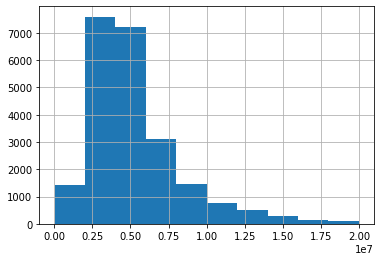

In [44]:
data['last_price'].hist()

Теперь мы видим ценовые тенденции. Основная часть недвижимости входит в ценовой диапазон от 2 до 5 миллионов рублей. 

Уберем данные с количеством комнат > 5.

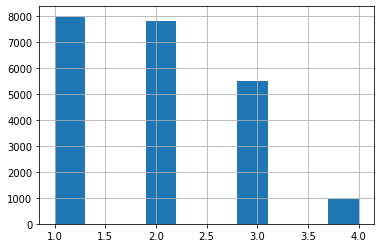

In [45]:
data= data.query('0 < rooms < 5')
data['rooms'].hist()

Здесь очень плавное распределение. Наибольший отрыв в количестве заметен только лишь у 4-кмн. квартир - тут предложение резко падает.

Опустим потолки в наших данных до 3 метров

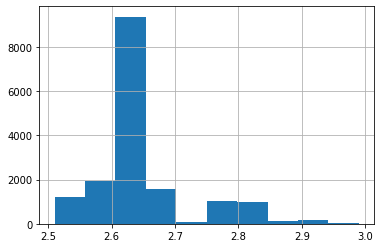

In [46]:
data= data.query('2.5 < ceiling_height < 3')
data['ceiling_height'].hist()

Тут распредление вполне обосновано и легко объяснимо: согласно нормативам минимальная высота потолка в квартирах - это 2.5 метра. Высота больше 2.7-3 метров - редкие исключения, так как нормативом уже предусмотрен определенный диапазон. 

ФАКТОРЫ, ВЛИЯЮЩИЕ НА СТОИМОСТЬ КВАРТИР

ЗАВИСИМОСТЬ ОТ ПЛОЩАДИ/КОМНАТ/БЛИЗОСТИ К ЦЕНТРУ

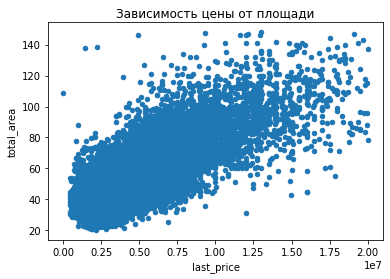

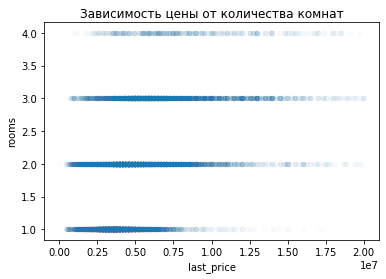

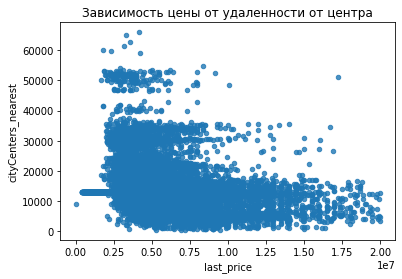

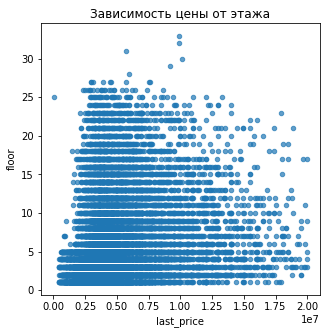

In [47]:
data.plot(x='last_price', y='total_area', kind='scatter', alpha=1, title='Зависимость цены от площади')
data.plot(x='last_price', y='rooms', kind='scatter', alpha=0.02, title='Зависимость цены от количества комнат')
data.plot(x='last_price', y='cityCenters_nearest', kind='scatter', alpha=0.8, title='Зависимость цены от удаленности от центра')
data.plot(x='last_price', y='floor', kind='scatter', alpha=0.7, figsize=(5,5), title='Зависимость цены от этажа')

In [48]:
data.pivot_table(index='floor_type', values='m_price', aggfunc='mean')

,m_price
floor_type,
Другой,98606.259694
Первый,78215.579064
Последний,84378.658098


Средняя стоимость квадратного метра на первом этаже ниже, чем на всех остальных, так как первый этаж помимо отсутствия необходимости в использовании лифта в себе никаких преимуществ особо не содержит: это шум с улицы (тем более если дом находится у дороги), отсуствие какой-либо панорамы, холод и отсутсвие солнечного света, а также некоторые вопросы к безопасности. 

Все последующие этажи стоят дороже, но стоимость неочевидно кореллирует с этажом, так как средняя цена кв.м. последнего этажа уже ниже, чем любого другого. 

Таким образом, мы видим следующую зависимость цены от типа этажа: от первого этажа цена начинает повышаться с каждым последующим этажом наверх, но в какой-то момент начинает снова падать и немного опускается к последнему этажу. 

Влияние площади на стоимость: чем больше площадь, тем больше стоимость квартиры. Вполне очевидная закономерность. Практически прямая зависимость указывает на то, что увеличение площади всегда приводит к увеличению стоимости недвижимости. Наиболее 

Влияние количества комнат на стоимость: график указывает на схожую с площадью тенденцию. Увеличение количества комнат - это увеличение площади и логичная корелляция со стоимостью квартиры. 

Удаленность от центра. Можно сказать о том, что если квартира удалена от центра более, чем на 20км, то стоимость недвижимости > 10млн.руб. встречается крайне редко. Подавляющая часть дорогой недвижимости сосредоточена в радиусе 10-20 км от центра Санкт-Петербурга.

Этажность: мы видим, что при стоимости более 10 млн.руб. этажность > 10 встречается крайне редко. Более дорогая недвижимость чаще всего находится ниже.

ЗАВИСИМОСТЬ СТОИМОСТИ КВАРТИРЫ ОТ ДАТЫ РАЗМЕЩЕНИЯ

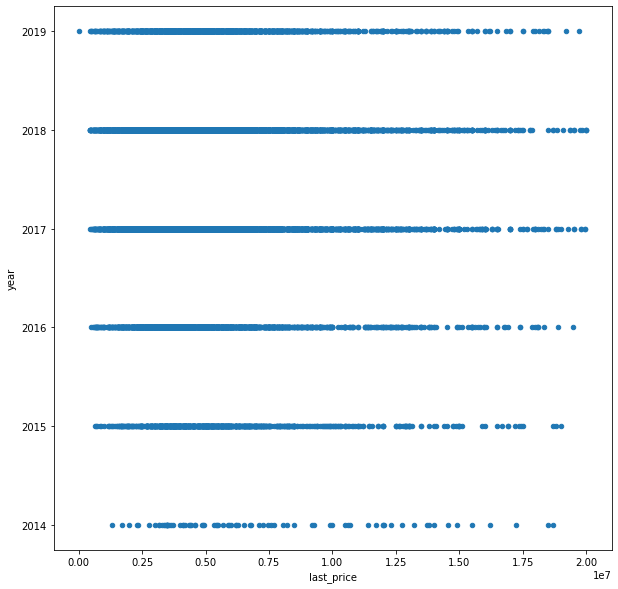

In [49]:
data.plot(x='last_price', y='year', kind='scatter', alpha=1, figsize=(10,10))

Начиная с 2014 года количество объявлений росло, а вместе с количеством - рос диапазон цен. Таким образом, мы видим, что недвижимость стоимостью более 12 млн.руб. была слабо представлена на рынке первые три года, а достигла пика предложения в 2018 году, но затем вновь пошла на убыль. Квартиры стоимостью до 12 млн.руб. на рынке были в достаточном количестве весь период наблюдений, кроме 2014 года, но тогда и общее количество объявлений было ниже. 

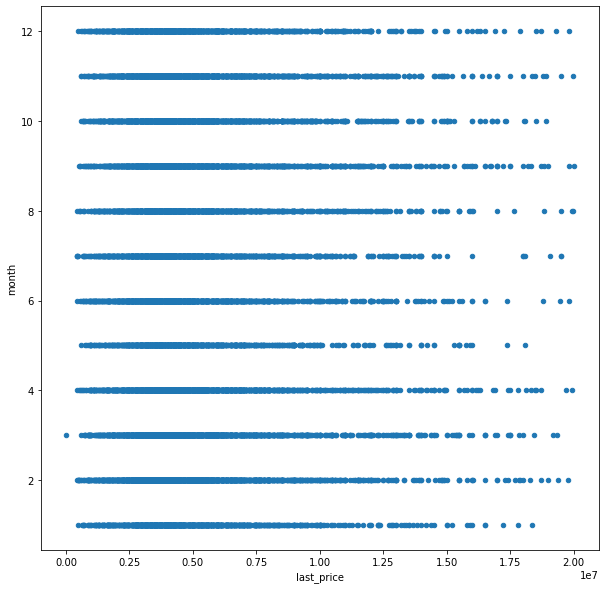

In [50]:
data.plot(x='last_price', y='month', kind='scatter', alpha=1, figsize=(10,10))

Единственные тенденции, которые можно проследить на этом графике, это опять те, которые касаются более дорогой недвижимости (>12млн.руб). Построим график, где посмотрим только на недвижимость стоимостью более 10 милн.руб. для большей наглядности. 

In [51]:
data_price_for_month=data.query('last_price > 10000000')

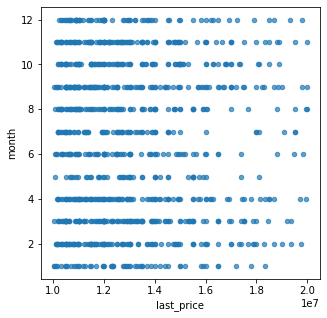

In [52]:
data_price_for_month.plot(x='last_price', y='month', kind='scatter', alpha=0.7, figsize=(5,5))

Даже при детальном рассмотрении достаточно сложно выявить какие-либо закономерности. Можно увидеть, что в летние месяцы есть незначительное понижение предложения в сегменте недвижимости стоимостью более 14 млн. Наиболее активными являются весенние и осенние периоды (апрель, сентябрь). Думаю, что это связано с тем, что в летний и зимний периоды из-за праздников люди не спешат заниматься вопросами, связанными с недвижимостью и предпочитают уделить время отпускам/хобби/личной жизни. 

Также, можно предположить, что в летний и зимний периоды люди выставляют недвижимость по более низкйо цене, так как из-за летних отпусков/зимних каникул находятся в более хорошем настроении :)

В целом, нет достаточно очевидной корелляции между месяцами и стоимостью недвижимости, которая в эти месяцы была выставлена на продажу. 

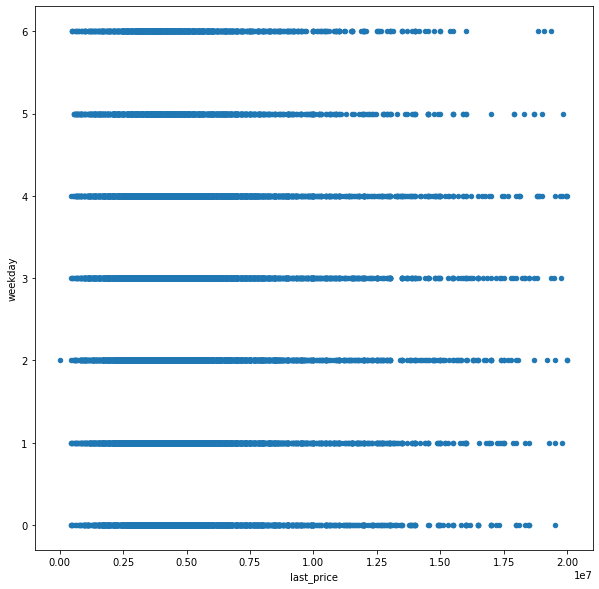

In [53]:
data.plot(x='last_price', y='weekday', kind='scatter', alpha=1, figsize=(10,10))

Очевидно, что в ср/чт/пт выкладывается больше объявлений, так как это разгар рабочей недели. В выходные и первые дни после выходных (пн/вт) люди не готовы заниматься этими вопросами. Аналогично, как и в случае с месяцами, я могу предположить, что более низкая цена на недвижимость также зависит от эмоционального фона человека: в выходные он склонен назначать более низкую цену, чем в середине рабочей недели, а тем более в ее конце (наибольшая цена в пятницу). 

10 НАСЕЛЕННЫХ ПУНКТОВ С НАИБОЛЬШИМ КОЛИЧЕСТВОМ ОБЪЯВЛЕНИЙ

Выберем 10 населённых пунктов с наибольшим числом объявлений. 
Посчитаем среднюю цену квадратного метра в этих населённых пунктах.

In [54]:
data_top10 = data.pivot_table(index='locality_name', values='m_price', aggfunc=('mean','count'))

In [55]:
data_top10.sort_values(by=['count', 'mean'], ascending=False).head(10)

,count,mean
locality_name,,
Санкт-Петербург,10630,108253.067552
Мурино,541,85410.414148
Кудрово,442,94988.710635
Шушары,402,78225.207412
Всеволожск,349,67200.398737
Парголово,307,90394.027059
Пушкин,239,102956.146271
Гатчина,216,68694.056402
Колпино,214,75424.900149


Выделим населённые пункты с самой высокой и низкой стоимостью жилья.

In [56]:
data_top10_price = data.pivot_table(index='locality_name', values='last_price', aggfunc=('mean','count'))

In [57]:
data_top10_groupby_price = data_top10_price.sort_values(by=['count', 'mean'], ascending=False).head(10)

In [58]:
#самая низкая стоимость жилья среди топ-10 самых популярных городов
data_top10_groupby_price.sort_values(by='mean')

,count,mean
locality_name,,
Выборг,170,3.045041e+06
Гатчина,216,3.529261e+06
Мурино,541,3.747288e+06
Всеволожск,349,3.760826e+06
Колпино,214,3.857076e+06
Шушары,402,4.153905e+06
Кудрово,442,4.437995e+06
Парголово,307,4.518588e+06
Пушкин,239,5.856468e+06


In [59]:
#самая высокая стоимость жилья среди топ-10 самых популярных городов
data_top10_groupby_price.sort_values(by='mean', ascending=False)

,count,mean
locality_name,,
Санкт-Петербург,10630,6.139267e+06
Пушкин,239,5.856468e+06
Парголово,307,4.518588e+06
Кудрово,442,4.437995e+06
Шушары,402,4.153905e+06
Колпино,214,3.857076e+06
Всеволожск,349,3.760826e+06
Мурино,541,3.747288e+06
Гатчина,216,3.529261e+06


Создадим столбец для Санкт-Петербурга с расстоянием до центра в километрах: округлим до целых значений.

In [60]:
data_center = data.query('locality_name == "Санкт-Петербург"')

In [61]:
data_center['center_saint'] = data_center['cityCenters_nearest']/1000
data_center['center_saint'] = data_center['center_saint'].round()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Посчитаем среднюю цену для каждого километра и построим график: он должен показывать, как цена зависит от удалённости от центра. 
Определим границу, где график сильно меняется — это и будет центральная зона.

In [62]:
data_center_new = data_center.pivot_table(index='center_saint', values='last_price', aggfunc='mean')

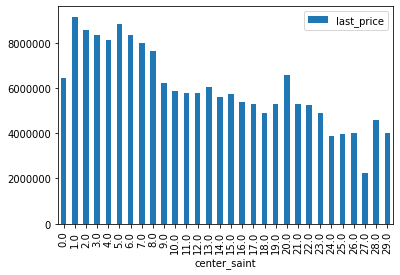

In [63]:
data_center_new.plot.bar()

Мы видим, что после границы в 8 км. средняя цена сильно падает. Выделим этот диапазон (1-8км), как относящийся к центру города.

ВЫДЕЛИМ СЕГМЕНТ КВАРТИР В ЦЕНТРЕ

In [64]:
data_center_analyse = data_center.query('center_saint < 9')

Проанализируем эту территорию и изучим следующие параметры: площадь, цена, число комнат, высота потолков.

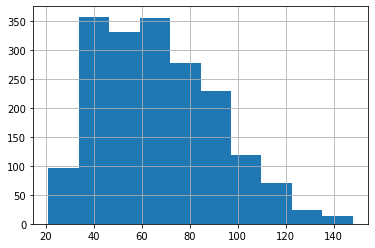

In [65]:
data_center_analyse['total_area'].hist()

В случае с аналитикой по всему городу мы видели, что пиковые значения в площади находятся в диапазоне 30-50кв.м. В центре этот дипапазон шире в большую сторону: 35-70 кв.м.

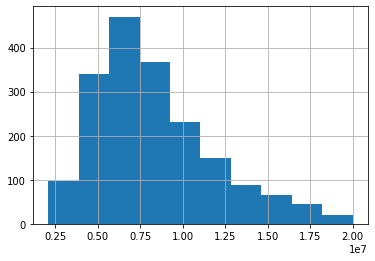

In [66]:
data_center_analyse['last_price'].hist()

Если в общей статистике мы выделяли большую долю недвижимости в ценовом диапазон 2-5млн, то в центре этот диапазон составляет 5-10 млн.руб. Чем к ближе к центру, тем больше средняя площадь и выше цена.

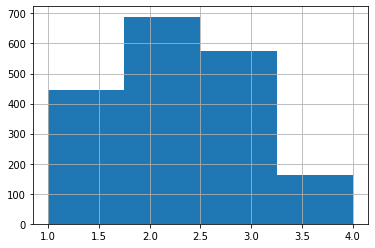

In [67]:
data_center_analyse['rooms'].hist(bins=4)

Аналогичный рост сопровождает количество комнат. В общей статистике лидировали 1 и 2 комн.квартиры, тогда как в центре мы видим, что больше всего объявлений тут с 2 и 3 кмн. квартирами. 

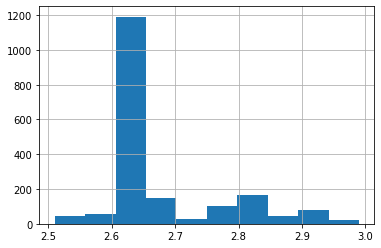

In [68]:
data_center_analyse['ceiling_height'].hist()

Цифры по высоте потолков практически не изменились. Стандарты везде одинаковые и нетипичные показатели (2.8/2.9м) тоже встречаются практически с одинаковой частотой. 

Также выделим факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделаем выводы. Найдем отличия от общих показателей по городу.

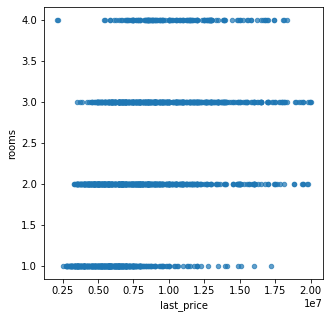

In [69]:
data_center_analyse.plot(x='last_price', y='rooms', kind='scatter', alpha=0.7, figsize=(5,5))

Вывод: комнатность имеет слабовыраженную связь с ценой. При цене более 12 млн.руб. реже встречаются однокомнатные квартиры. Основную массу в более дорогой недвижимости составляют 3-комн. квартиры. 
Отличие от общих показателей: мы видим, что в центре присутствует бóльшая концентрация 2-х, 3-х и 4-х комнатных квартир. Это логично: основная масса студий и 1-кмн квартир сосредоточена в спальных районах города: Кудрово, Мурино и т.п. 

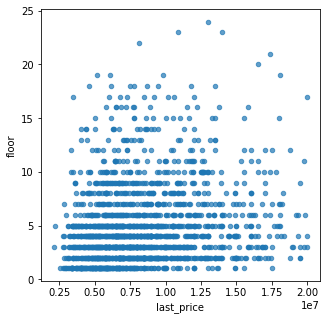

In [70]:
data_center_analyse.plot(x='last_price', y='floor', kind='scatter', alpha=0.7, figsize=(5,5))

Аналогично, как и в случае с остальными данными по городу, в центре наиболее часто встречающийся этаж квартиры - до 10 этажа. 

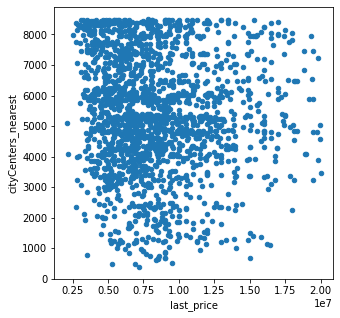

In [71]:
data_center_analyse.plot(x='last_price', y='cityCenters_nearest', kind='scatter', alpha=1, figsize=(5,5))

Незначительная зависимость в границах центра наблюдается у цены и удаленности от центра. Можно заметить, что недвижимость, расположенная в радиусе до 4км от центра чаще всего стóит не менее 5 млн.руб. Примерно в равной степени распределена удаленность дорогой недвижимости (более 10 млн.руб), но все таки более сконцентрирована в радиусе от 3 до 6 км от центра. 

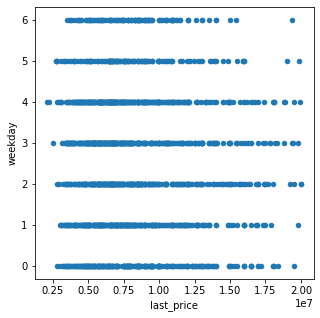

In [72]:
data_center_analyse.plot(x='last_price', y='weekday', kind='scatter', alpha=1, figsize=(5,5))

Аналогичная с выводами по всей недвижимости зависимость цены от дня размещения объявления. Размещенная в выходные, понедельник и вторник недвижимость стоит дешевле, чем размещенная на сайте в середине недели (ср/чт/пт). 

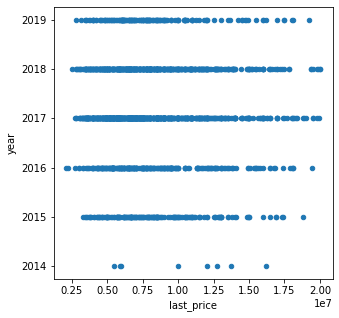

In [73]:
data_center_analyse.plot(x='last_price', y='year', kind='scatter', alpha=1, figsize=(5,5))

Похожая история и с годом размещения объявления. Начиная с 14 года росло общее количество объявлений, а вместе с ним  и объявления о более дорогой недвижимости: пик таких объявлений приходится на 2017/2018 год. 

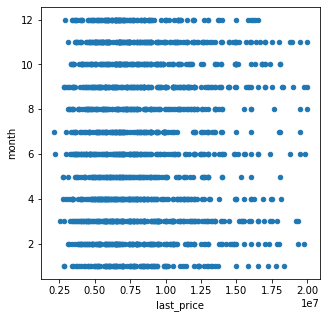

In [74]:
data_center_analyse.plot(x='last_price', y='month', kind='scatter', alpha=1, figsize=(5,5))

Посмотрим ближе: оставим только объявления о продаже недвижимости более 10 млн.руб. 

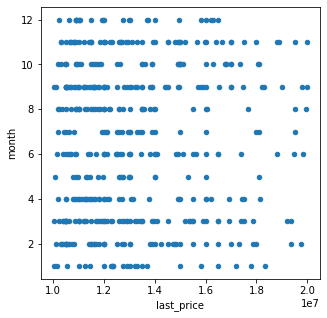

In [75]:
data_center_analyse.query('last_price > 10000000').plot(x='last_price', y='month', kind='scatter', alpha=1, figsize=(5,5))

Так же, как и в случае с общей аналитикой, в центре наиболее активно продажа дорогой недвижимости начинается в весенние/осенние месяцы. 

### Шаг 5. Общий вывод

По итогам проведенного исследования мы можем выделить несколько наиболее очевидных тенденций и зависимостей: 

- ПЛОЩАДЬ: цена за недвижимость зависит от площади квартиры (с площадью, чаще всего, повышается и комнатность квартиры)
- КОЛИЧЕСТВО КОМНАТ: в общей статистике наиболее выделяется сегмент предложения 1 и 2-х комнатных квартир, но чем ближе мы к центру, тем больше комнат становится: 2-х и 3-х комнатные квартиры лидируют по количеству объявлений в центре Санкт-Петербурга
- ВЫСОТА ПОТОЛКОВ: как либо категоризировать эти данные или найти у высоты потолков высокую корелляцию с каким-либо показателем не представляется возможным, так как эта характеристика имеет общепринятые стандарты в строительстве: потолки не могут быть ниже 2.5 метров, где бы не находилась ваша квартира (больше можно, меньше нельзя)
- ДАТА: зависимость цены от года/месяца/дня недели. ГОД: мы видим всплеск объявлений недвижимости в 2017/2018 году, а в частности более дорогой недвижимости. Думаю, что это не в последнюю очередь связано с финансовым кризисом 18-ого года, когда сильно вырос курс доллара и евро - люди начали продавать недвижимости больше, чем покупать. МЕСЯЦ: Наиболее очевидны всплески предложения в весенние и осенние месяцы. Думаю, что это связано с тем, что в зимние и летние месяцы люди чаще находятся в отпусках/заняты личными делами. Возможно, также, что низкое количество объявлений о продаже дорогой недвижимости также неслучайно кореллирует с сезоном зима/лето: летние месяцы и периоды новогодних каникул распологают! :) ДЕНЬ: мы видим, что в выходные дни и следующие за ними пн и вт люди склонны выкладывать меньше объявлений о продаже недвижимости и ставить более низкую цену в эти дни. Количество объявлений можно объяснить тем, что в выходные люди заняты другими делами, а те кто выкладывают в эти дни объявления - склонны поставить более низкую цену из-за эмоционального фона, который можеть быть более положительным, когда ты выходной :)
- ЭТАЖ: основная масса квартир сконцентрирована до 5-ого этажа. Все, что выше - стоит уже немного дороже и попадается реже. Четкой зависимости нет. 
- БЛИЗОСТЬ К ЦЕНТРУ: чем ближе мы подбираемся к центру, тем: больше площадь квартир, больше комнат, выше стоимость недвижимости. Это вполне объяснимая закономерность, ведь близость к центру всегда сильно влияет на стоимость недвижимости. Что касается комнат и площади, то можно отметить, что в спальных районах города (типа Мурино, Кудрово) строится больше бюджетного жилья - это буквально целые кварталы из студий и "однушек" (если вы из Питера,то у вас наверняка есть минимум пара друзей, которые купили там однушку или студию в ипотеку - уже сильная статистика!). В центре сосредоточен в основном старый фонд, где большая площадь квартир исторически обусловлена, также, как и количество комнат и высота потолков. 